In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, cross_validate

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, recall_score, make_scorer


from sklearn.linear_model import LogisticRegression

from matplotlib_venn import venn2
from tqdm import tqdm

from imblearn.over_sampling import SMOTENC



import src.features as features
import src.model_selection as model_selection 
import src.functions as functions
import src.datasets as datasets 

# import custom functions
from src.functions import plot_correlations, plot_mutual_info, hello
from src.datasets import xy_train, xy_train_test, data_original, data_50000, data_balanced


## Prepare

In [51]:
data = datasets.data_original()

In [52]:
data = features.engineer(data)

In [53]:
### Train test split (unprocessed)
X_, y_ = data.drop('infected', axis=1), data['infected']
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, test_size = 0.2, random_state=42, stratify = y_)


In [54]:
scaler = StandardScaler()

scaler.fit(X_train_)

X_train_scaled = scaler.transform(X_train_)
X_test_scaled = scaler.transform(X_test_)

In [57]:
X_train_.reset_index(inplace = True,drop = True)
y_train_.reset_index(inplace = True, drop = True)

In [58]:
X_train =pd.DataFrame(X_train_scaled,columns=X_.columns)
X_test =pd.DataFrame(X_test_scaled,columns=X_.columns)
y_train = y_train_
y_test = y_test_ 

## Analyze offtrt interaction

In [60]:
coefficients = []

model = LogisticRegression(random_state=42)
model0 = LogisticRegression(random_state=42)
model1 = LogisticRegression(random_state=42)

col = "offtrt"

X0 = X_train[X_train[col] < 0]
X1 = X_train[X_train[col] > 0]

y0 = y_train[X_train[col] < 0]
y1 = y_train[X_train[col] > 0]

n0 = X0.shape[0]
n1 = X1.shape[0]
n = n0+n1

model.fit(X_train,y_train)
model0.fit(X0,y0)
model1.fit(X1,y1)

LogisticRegression(random_state=42)

In [62]:
coef = pd.DataFrame({
    "model" : "origin",
    "feature" : X_train.columns,
    "coefficient": model.coef_[0]
})
coef0 = pd.DataFrame({
    "model" : col+ "0",
    "feature" : X_train.columns,
    "coefficient": model0.coef_[0]
})
coef1 = pd.DataFrame({
    "model" : col+ "1",
    "feature" : X_train.columns,
    "coefficient": model1.coef_[0]
})

coefficients_df = pd.concat([coef,coef0,coef1])




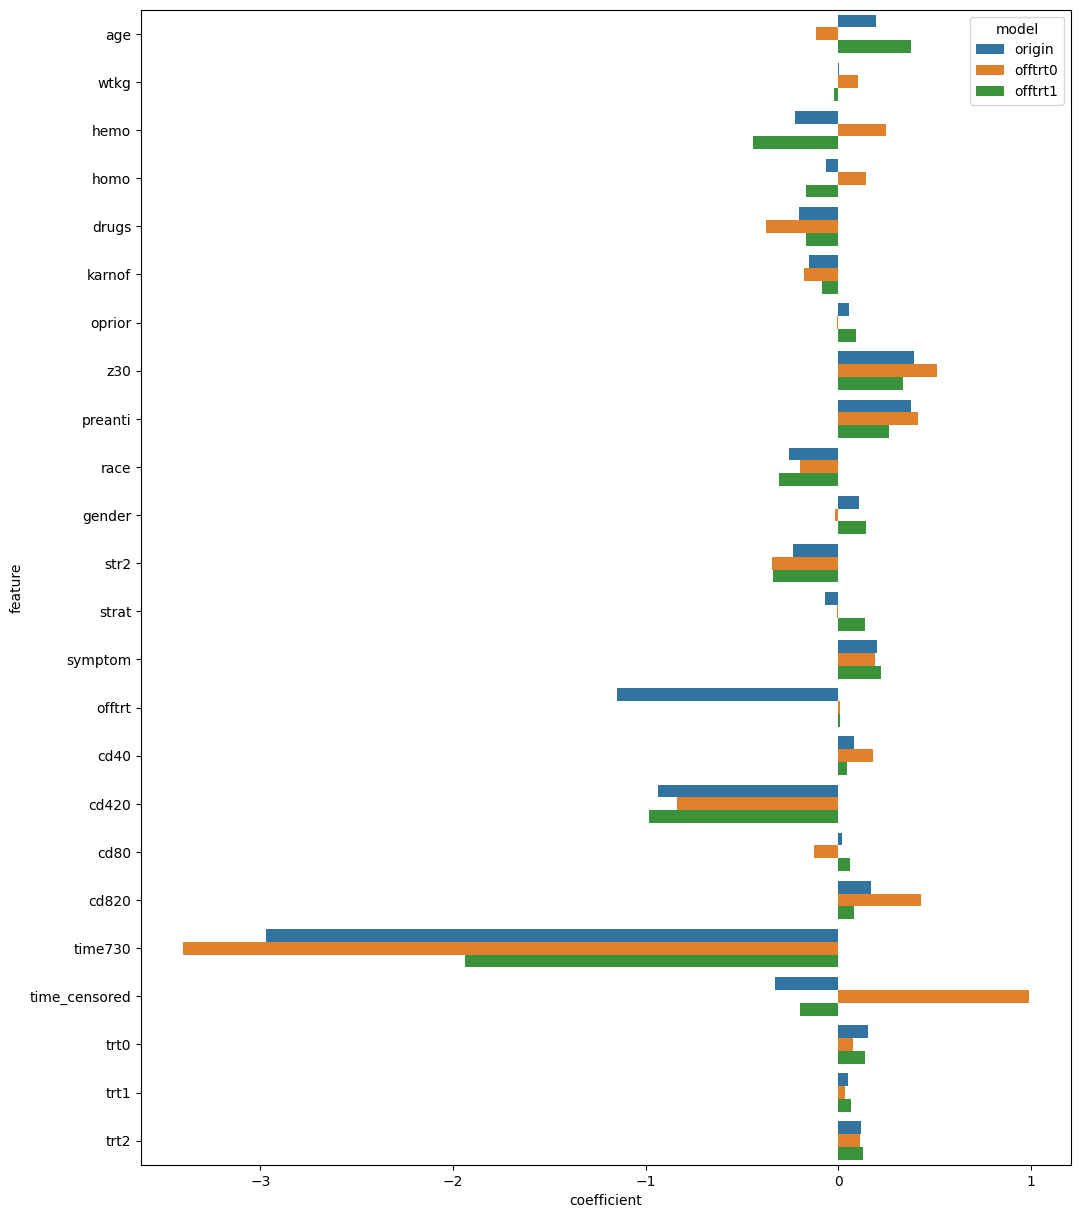

In [65]:
#fig, axes = plt.subplots(1,3, figsize = (9,10))
plt.figure(figsize = (12,15))
sns.barplot(data = coefficients_df, y = "feature", x = "coefficient", hue = "model")

plt.show()

## Ready

In [9]:
model = LogisticRegression(random_state=42)

In [10]:
from src.model_selection import validation_accuracy_score as score

In [11]:
acc = score(X_train,y_train, model, 3)

In [12]:
acc

np.float64(0.8860294343564691)

### Bin features

In [13]:
bin_features = [col for col in X_train.columns if X_train[col].nunique() == 2]
bin_features

['hemo',
 'homo',
 'drugs',
 'oprior',
 'z30',
 'race',
 'gender',
 'str2',
 'symptom',
 'offtrt',
 'trt0',
 'trt1',
 'trt2']

In [15]:
"""r = []

for col in bin_features:

    X0 = X_train[X_train[col] < 0]
    X1 = X_train[X_train[col] > 0]

    y0 = y_train[X_train[col] < 0]
    y1 = y_train[X_train[col] > 0]

    n0 = X0.shape[0]
    n1 = X1.shape[0]
    n = n0+n1

    acc0 = score(X0,y0,LogisticRegression(random_state = 42), 3)
    acc1 = score(X1,y1,LogisticRegression(random_state = 42), 3)

    results = {
        "col" : col,
        "n0" : n0,
        "n1" : n1,
        "acc0" : acc0, 
        "acc1" : acc1,
        "acc01" : (acc0 * n0 + acc1*n1) / (n0+n1), 
        "acc" : acc
    }

    for i in "acc acc0 acc1 acc01".split():
        results[i] = round(results[i],4)
        results[i] = float(results[i])

    r.append(results)

rr = pd.DataFrame(r)
rr
"""



'r = []\n\nfor col in bin_features:\n\n    X0 = X_train[X_train[col] < 0]\n    X1 = X_train[X_train[col] > 0]\n\n    y0 = y_train[X_train[col] < 0]\n    y1 = y_train[X_train[col] > 0]\n\n    n0 = X0.shape[0]\n    n1 = X1.shape[0]\n    n = n0+n1\n\n    acc0 = score(X0,y0,LogisticRegression(random_state = 42), 3)\n    acc1 = score(X1,y1,LogisticRegression(random_state = 42), 3)\n\n    results = {\n        "col" : col,\n        "n0" : n0,\n        "n1" : n1,\n        "acc0" : acc0, \n        "acc1" : acc1,\n        "acc01" : (acc0 * n0 + acc1*n1) / (n0+n1), \n        "acc" : acc\n    }\n\n    for i in "acc acc0 acc1 acc01".split():\n        results[i] = round(results[i],4)\n        results[i] = float(results[i])\n\n    r.append(results)\n\nrr = pd.DataFrame(r)\nrr\n'

Resutls: technique is good for "offtrt" and "trt2", ti is ad otherwise. 

It is especially good on offtrt = 0. 

It is good-ish on "gender"= 0 and "trt = 0"

## time

In [28]:
data = datasets.data_original()
data = features.engineer(data, time = None)
### Train test split (unprocessed)
X_, y_ = data.drop('infected', axis=1), data['infected']
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, test_size = 0.2, random_state=42, stratify = y_)

scaler = StandardScaler()

scaler.fit(X_train_)

X_train_scaled = scaler.transform(X_train_)
X_test_scaled = scaler.transform(X_test_)
y_train_.reset_index(inplace = True, drop = True)
X_train =pd.DataFrame(X_train_scaled,columns=X_.columns)
X_test =pd.DataFrame(X_test_scaled,columns=X_.columns)
y_train = y_train_
y_test = y_test_ 

In [29]:
X_train_.reset_index(inplace = True,drop = True)
X_train_

,time,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,preanti,...,strat,symptom,offtrt,cd40,cd420,cd80,cd820,trt0,trt1,trt2
0,967,38,77.7000,0,0,1,90,0,1,817,...,3,0,1,356,341,499,614,1,0,0
1,896,38,68.0400,0,1,0,100,0,0,0,...,1,1,0,177,433,1242,1347,0,1,0
2,977,30,78.4728,0,1,0,100,0,0,0,...,1,0,0,389,355,654,397,0,0,0
3,894,28,58.5144,0,1,0,100,0,0,1016,...,3,0,0,549,475,875,591,0,0,0
4,1167,49,100.0000,0,1,0,90,0,1,1500,...,3,0,0,428,349,500,449,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1706,1160,24,71.0000,0,0,0,100,0,0,0,...,1,0,0,439,428,2069,1305,0,1,0
1707,575,24,61.6896,0,0,0,90,0,0,34,...,2,0,0,210,231,1327,1733,0,1,0
1708,419,37,79.8336,0,1,0,100,0,0,0,...,1,1,0,356,324,2884,2106,0,0,0
1709,1032,40,75.7512,0,1,0,90,0,0,0,...,1,0,0,308,487,868,1104,0,1,0


In [31]:
col = "time"

X0 = X_train[X_train_[col] < 730]
X1 = X_train[X_train_[col] >= 730]

y0 = y_train[X_train_[col] < 730]
y1 = y_train[X_train_[col] >= 730]

n0 = X0.shape[0]
n1 = X1.shape[0]
n = n0+n1

acc0 = score(X0,y0,LogisticRegression(random_state = 42), 3)
acc1 = score(X1,y1,LogisticRegression(random_state = 42), 3)

results = {
    "col" : col,
    "n0" : n0,
    "n1" : n1,
    "acc0" : acc0, 
    "acc1" : acc1,
    "acc01" : (acc0 * n0 + acc1*n1) / (n0+n1), 
    "acc" : acc
}

for i in "acc acc0 acc1 acc01".split():
    results[i] = round(results[i],4)
    results[i] = float(results[i])

print(results)

r = []
r.append(results)

rr = pd.DataFrame(r)
rr


{'col': 'time', 'n0': 433, 'n1': 1278, 'acc0': 0.7945, 'acc1': 0.9155, 'acc01': 0.8849, 'acc': 0.886}


NameError: name 'r' is not defined

It is good on "time>=730" but then on average is not so good. 

## trt

In [36]:
data = datasets.data_original()
data = features.engineer(data)
### Train test split (unprocessed)
X_, y_ = data.drop('infected', axis=1), data['infected']
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, test_size = 0.2, random_state=42, stratify = y_)
X_train_.reset_index(inplace = True,drop = True)


scaler = StandardScaler()

scaler.fit(X_train_)

X_train_scaled = scaler.transform(X_train_)
X_test_scaled = scaler.transform(X_test_)
y_train_.reset_index(inplace = True, drop = True)
X_train =pd.DataFrame(X_train_scaled,columns=X_.columns)
X_test =pd.DataFrame(X_test_scaled,columns=X_.columns)
y_train = y_train_
y_test = y_test_ 

In [44]:
X_train["trt3"] = 0.5 - X_train_["trt0"] -X_train_["trt1"] - X_train_["trt2"]

In [49]:

XX  = [0,0,0,0]
yy = [0,0,0,0]
nn = [0,0,0,0]
accc = [0,0,0,0]
accw = [0,0,0,0]

for i in range(4):
    col = "trt" + str(i)
    XX[i] = X_train[X_train[col] > 0]
    yy[i] = y_train[X_train[col] > 0]
    nn[i] = XX[i].shape[0]
    accc[i] = score(XX[i],yy[i],LogisticRegression(random_state = 42), 3)
    accw[i] = accc[i] * nn[i] 

    print(col, nn[i], accc[i])

acctot  =    sum(accw) / sum(nn)

print(acc, "old")
print(acctot, "new")

trt0 433 0.8614463601532568
trt1 409 0.8875590382138258
trt2 418 0.8756252141144228
trt3 451 0.893568800588668
0.8860294343564691 old
0.8796193975108901 new


## Coefficients

Now we need to check coefficients for offtrt